# Exercise 5.6.2

**Medium**: Simulate an AR(p) process and make forecasts: 
1. Recreate the previous exercise but simulating an AR(p) process of your choice.  Experiment with a third or fourth-order autoregressive process. I would recommend generating 10,000 samples. 
2. When forecasting, experiment different values for the `window` parameter of your `recursive_forecast` function. How does it affect the model’s performance? Is there a value that minimizes the MSE?


In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '/home/oliver/Documents/Code/myrepos/TimeSeriesForecastingInPython/MyWork/../../My-Code/timetools.py'>

In [25]:
# simulation of stationary AR(2) process

np.random.seed(42)

ma = np.array([1, 0, 0, 0])
ar = np.array([1, -0.33, -0.50, -0.13])

ar2 = ArmaProcess(ar=ar, ma=ma).generate_sample(nsample=10000)

In [26]:
ar2[-10:]

array([-1.15410385, -2.03448893, -0.9819238 , -2.98994832, -0.54791392,
       -0.50233378, -2.82676536, -1.96054499, -1.62990035, -1.24123066])

Test Statistic                -1.052950e+01
p-value                        9.230456e-19
#Lags Used                     2.000000e+00
Number of Observations Used    9.997000e+03
Critical Value (1%)           -3.431004e+00
Critical Value (5%)           -2.861829e+00
Critical Value (10%)          -2.566924e+00
dtype: float64

The time series is stationary.


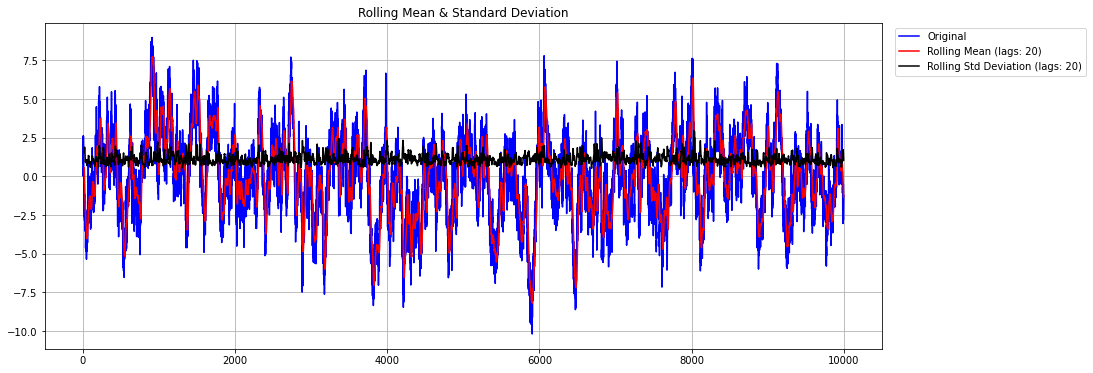

In [27]:
# Plot your simulated autoregressive process.
# Run the ADF test and check if the process is stationary. If not, apply differencing.
tt.adf(pd.Series(ar2))
tt.plot_for_stationary(pd.Series(ar2))

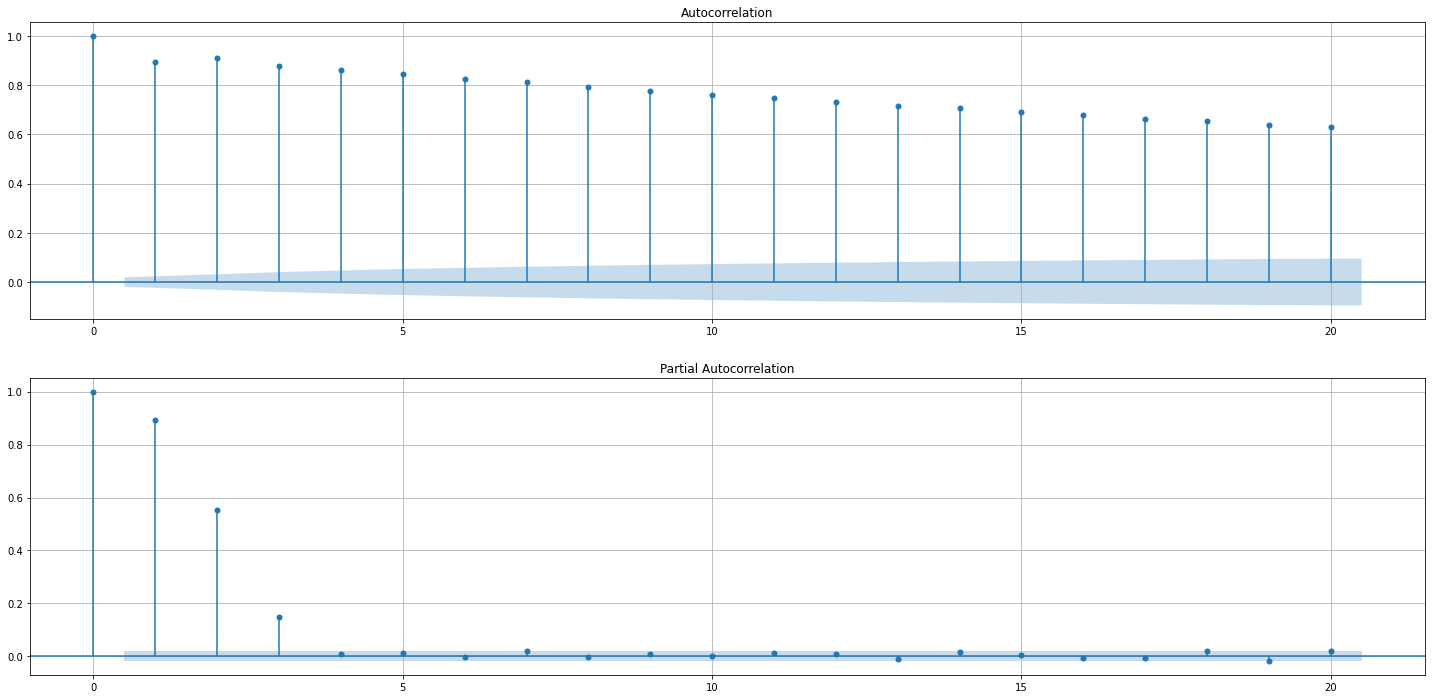

In [28]:
# Plot the ACF. Is it slowly decaying?
# Plot the PACF. Are there significant coefficients after lag 2?

tt.plot_acf_pcf(pd.Series(ar2), num_lag=20)

Yes, the ACF plot is slowly decaying and the PACF plot shows insignificant coefficients.  Hence, it's an autoregressive process.

In [29]:
# Separate your simulated series into a training and test set. Take the first 800
# timesteps for the training set and assign the rest to the test set.

df = pd.DataFrame(ar2, columns=['value'])
train, test = df[:-2000], df[-2000:]

In [30]:
print(df.shape[0])
print(len(train))
print(len(test))

10000
8000
2000


Make forecasts over the test set. Use the historical mean method, last value method, and an AR(2) model. Use the `recursive_forecast` function and use a `window` length of 2.

In [31]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [32]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_AR'] = pred_AR

pred_df.head()

,value,pred_mean,pred_last_value,pred_AR
8000,5.564528,-0.119198,6.532642,5.547354
8001,5.361636,-0.119198,6.532642,5.875530
8002,5.228472,-0.117802,5.361636,5.439535
8003,5.844334,-0.117802,5.361636,5.213009
8004,6.517736,-0.116389,5.844334,5.241211


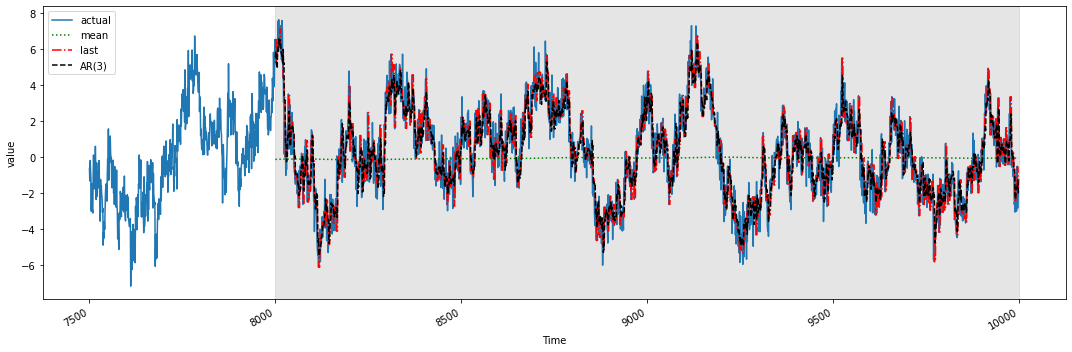

In [48]:
# Plot your forecasts

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df[7500:]['value'], label='actual')
ax.plot(pred_df.pred_mean, 'g:', label='mean')
ax.plot(pred_df.pred_last_value, 'r-.', label='last')
ax.plot(pred_df.pred_AR, 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('value')

ax.axvspan(8000, 10000, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [35]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

6.071829042622366 1.3441723493176259 1.0303644962651375


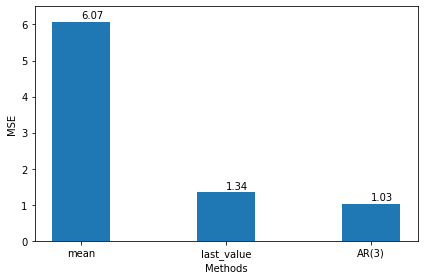

In [37]:
# Plot your MSEs in a bar plot

fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'AR(3)'], 
    [mse_mean, mse_last, mse_AR], 
    width=0.4)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 6.5)

ax.text(y=mse_mean+0.1, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+0.1, x=1, s=round(mse_last, 2))
ax.text(y=mse_AR+0.1, x=2, s=round(mse_AR, 2))

plt.tight_layout()

### Different WINDOW  

window = 3

In [44]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

pred_df['pred_mean'] = pred_mean[:-1]
pred_df['pred_last_value'] = pred_last_value[:-1]
pred_df['pred_AR'] = pred_AR[:-1]

pred_df.head()

,value,pred_mean,pred_last_value,pred_AR
8000,5.564528,-0.119198,6.532642,5.547354
8001,5.361636,-0.119198,6.532642,5.875530
8002,5.228472,-0.119198,6.532642,5.590682
8003,5.844334,-0.117134,5.228472,5.147279
8004,6.517736,-0.117134,5.228472,5.024508


In [45]:
# Measure the MSE and identify your champion model

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

6.072437819650335 1.4783395306796687 1.1530849923459534


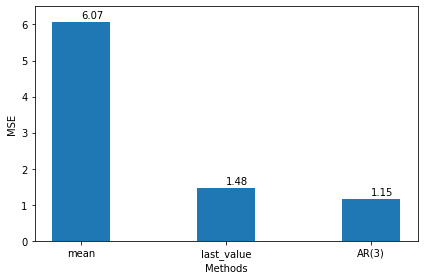

In [46]:
# Plot your MSEs in a bar plot

fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'AR(3)'], 
    [mse_mean, mse_last, mse_AR], 
    width=0.4)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 6.5)

ax.text(y=mse_mean+0.1, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+0.1, x=1, s=round(mse_last, 2))
ax.text(y=mse_AR+0.1, x=2, s=round(mse_AR, 2))

plt.tight_layout()

Changing the `window` from `2` to `3` resulted in a `higher Mean Squared Error (MSE)` for the last-value and AR(3) methods.